In [220]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [425]:
#There are deleted users among these votes. To Take into account only active users refer to  ExploratoryPlotsByGroups.ipynb
votes = pd.DataFrame.from_csv('c:/Users/Joel/Predictive-model-for-the-voting-system-in-SE-network/spanish_site/AnsVotes_TSeries.csv', index_col=None)
votes.head()

,QuestionId,AnsId,Age_vot,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,Upvotes,...,CumScore,ReScore,QReScore,Comments,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias
0,1,56,0,201,56,0,0,2,2,2,...,0,0,0,0,1,1,1,1,0,1
1,2,10,0,145,10,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1
2,2,10,0,145,10,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1
3,3,9,0,25,109,0,0,4,4,4,...,0,0,0,0,1,1,1,1,0,1
4,7,16,0,45,2977,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1


In [426]:
# Little test
votes[(votes.Upvotes.isnull())|(votes.Downvotes.isnull())]

,QuestionId,AnsId,Age_vot,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,Upvotes,...,CumScore,ReScore,QReScore,Comments,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias


In [427]:
votes[votes.Votes != (votes.Upvotes+votes.Downvotes)]

,QuestionId,AnsId,Age_vot,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,Upvotes,...,CumScore,ReScore,QReScore,Comments,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias


In [428]:
votes.columns

Index([u'QuestionId', u'AnsId', u'Age_vot', u'AnsWordCount', u'AcceptedAnsId',
       u'QScore', u'QVotes', u'Score', u'Votes', u'Upvotes', u'Downvotes',
       u'CumVotes', u'CumScore', u'ReScore', u'QReScore', u'Comments',
       u'AnsRank', u'ReScore_rank', u'Ans_count', u'Pbias', u'DRank',
       u'EPbias'],
      dtype='object')

In [429]:
votes['Norm_Pos'] = votes['AnsRank']/votes['Ans_count']
votes['Norm_DRank'] = votes['DRank']/votes['Ans_count']

In [430]:
votes.shape

(23328, 24)

### Distribution of : number of days an answer is voted on (at least one vote)

In [431]:
votes.groupby('AnsId').count().Age_vot.value_counts().head(15)

1     1638
2     1405
3      740
4      598
6      292
5      217
8      153
12      97
10      71
9       62
7       45
16      31
18      28
15      25
24      25
Name: Age_vot, dtype: int64

# Regression happens on votes the day after attributes were measured

In [432]:
atts = ['Age_vot','Norm_Pos','Norm_DRank','Ans_count','ReScore','AnsRank']
select = lambda df,one_vote=True: df[atts + ['Votes','Upvotes','Downvotes']] if one_vote else df[atts]
shift = lambda df,att : df[att].shift(-1).ffill()
shift_select = lambda df: select(df) if df.shape[0]==1 else pd.concat([select(df,one_vote=False),shift(df,'Votes'),shift(df,'Upvotes'),shift(df,'Downvotes')],axis=1)
shift_votes = lambda df: shift_select(df.sort_values(by='Age_vot'))

votes = votes.groupby(['AnsId']).apply(shift_votes).reset_index(level=[0],drop=False)

In [433]:
votes.shape #shape should be the same

(23328, 10)

In [434]:
votes.groupby('AnsId').count().Age_vot.value_counts().head(15)

1     1638
2     1405
3      740
4      598
6      292
5      217
8      153
12      97
10      71
9       62
7       45
16      31
18      28
15      25
24      25
Name: Age_vot, dtype: int64

In [435]:
votes[votes.Votes != (votes.Upvotes+votes.Downvotes)]

,AnsId,Age_vot,Norm_Pos,Norm_DRank,Ans_count,ReScore,AnsRank,Votes,Upvotes,Downvotes


In [436]:
votes.head(20)

,AnsId,Age_vot,Norm_Pos,Norm_DRank,Ans_count,ReScore,AnsRank,Votes,Upvotes,Downvotes
7132,4,0,1.000000,0.000000,2,0.000000,2,1,1,0
21434,4,1436,0.500000,-0.333333,6,0.250000,3,1,1,0
13998,5,0,1.000000,0.000000,3,0.000000,3,1,0,1
20327,5,108,1.000000,0.400000,5,0.500000,5,1,0,1
20328,6,0,1.000000,0.000000,5,0.000000,5,1,1,0
19213,8,0,0.750000,0.500000,4,0.000000,3,1,1,0
3,9,0,1.000000,0.000000,1,0.000000,1,1,1,0
22248,9,12,0.250000,0.000000,8,0.800000,2,1,1,0
22249,9,361,0.250000,0.000000,8,0.833333,2,1,1,0
22250,9,400,0.250000,0.000000,8,0.857143,2,1,1,0


# Exploratory plots

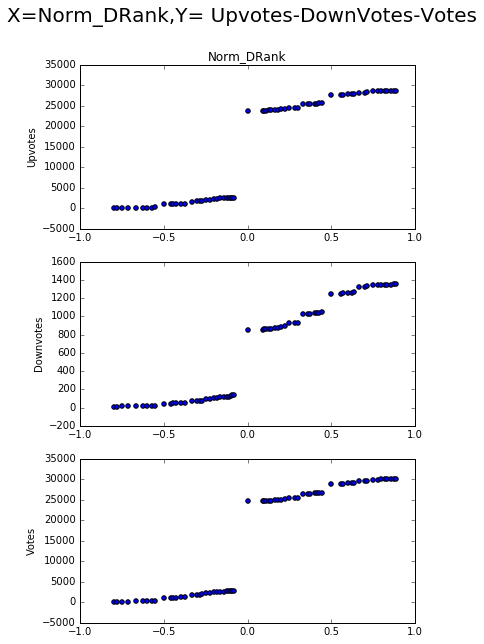

In [437]:
plt.figure(figsize=(6,10))

axref = plt.subplot(3,1,1)
plt.subplot(3, 1, 1,sharex=axref)
cumvotes_uv = votes.groupby(['Norm_DRank']).sum()['Upvotes'].cumsum()
plt.scatter(x = cumvotes_uv.index.values,y=cumvotes_uv.values)
plt.title('Norm_DRank')
plt.ylabel('Upvotes')

plt.subplot(3, 1, 2,sharex=axref)
cumvotes_dv = votes.groupby(['Norm_DRank']).sum()['Downvotes'].cumsum()
plt.scatter(x = cumvotes_dv.index.values,y=cumvotes_dv.values)
plt.ylabel('Downvotes')

plt.subplot(3, 1, 3,sharex=axref)
cumvotes_v = votes.groupby(['Norm_DRank']).sum()['Votes'].cumsum()
plt.scatter(x = cumvotes_v.index.values,y=cumvotes_v.values)
plt.ylabel('Votes')

plt.suptitle('X=Norm_DRank,Y= Upvotes-DownVotes-Votes',fontsize=20)
plt.show()

# Group predictors

In [501]:
def get_intervals(att,quantiles):
    qtls = votes[att].quantile(quantiles).values
    return dict(zip(zip(qtls,qtls[1:]),[e for e in range(len(zip(qtls,qtls[1:])))]))
    
def get_group(intervals,pred):
    for l,u in intervals:
        if l<=pred and pred<u:
            return intervals[(l,u)]
        
def reverse_groups(groups,unit='days'):
    if unit == 'Rel Score':
        return {groups[(d1,d2)]:"%.2f to %.2f %s"%(d1,d2,unit) for d1,d2 in groups}
    elif unit in ['Position','Nbr Ans Per Question']:
        return {groups[(d1,d2)]:"[%d - %d[ %s"%(d1,d2,unit) for d1,d2 in groups} 
    else:
        return {groups[(d1,d2)]:"%d to %d %s"%(d1,d2,unit) for d1,d2 in groups}

In [502]:
from functools import partial

age_intervals = get_intervals('Age_vot',[0,.25,.5,.75,1.0])
pos_intervals = get_intervals('AnsRank',[0,.6,.7,.8,.9,1.0])
rscore_intervals = get_intervals('ReScore',[0,.25,.5,.75,.85,1.0])
anscount_intervals = get_intervals('Ans_count',[0,.25,.5,.75,1.0])


In [503]:
votes['Age_vot_group'] = votes['Age_vot'].apply(partial(get_group,age_intervals))
votes['AnsRank_group'] = votes['AnsRank'].apply(partial(get_group,pos_intervals))
votes['ReScore_group'] = votes['ReScore'].apply(partial(get_group,rscore_intervals))
votes['Ans_count_group'] = votes['Ans_count'].apply(partial(get_group,anscount_intervals))

In [504]:
ReverseGroups = {}
ReverseGroups['Age_vot_group'] = reverse_groups(age_intervals)
ReverseGroups['AnsRank_group'] = reverse_groups(pos_intervals,unit='Position')
ReverseGroups['ReScore_group'] = reverse_groups(rscore_intervals,unit='Rel Score')
ReverseGroups['Ans_count_group'] = reverse_groups(anscount_intervals,unit='Nbr Ans PerQuestion')

In [505]:
ReverseGroups['Age_vot_group']

{0: '0 to 1 days', 1: '1 to 7 days', 2: '7 to 229 days', 3: '229 to 1504 days'}

In [506]:
ReverseGroups['AnsRank_group']

{0: '[1 - 1[ Position',
 1: '[1 - 2[ Position',
 2: '[2 - 2[ Position',
 3: '[2 - 3[ Position',
 4: '[3 - 11[ Position'}

In [507]:
ReverseGroups['ReScore_group']

{0: '-0.86 to 0.00 Rel Score',
 1: '0.00 to 0.67 Rel Score',
 2: '0.67 to 0.85 Rel Score',
 3: '0.85 to 0.89 Rel Score',
 4: '0.89 to 0.98 Rel Score'}

In [509]:
ReverseGroups['Ans_count_group']

{0: '1 to 1 Nbr Ans PerQuestion',
 1: '1 to 2 Nbr Ans PerQuestion',
 2: '2 to 3 Nbr Ans PerQuestion',
 3: '3 to 12 Nbr Ans PerQuestion'}

In [510]:
votes = votes[votes.ReScore_group.notnull()] #TODO:check ReScore group for extremely high ReScore obs

# Group Plots

In [511]:
from itertools import product
def plot_by(filtered_df,row_att_n, col_att_n,xpred_n,ypred_n,xfsize,yfsize,verbose=False):
    plt.figure(figsize=(xfsize,yfsize))
    
    row_group_name = row_att_n+'_group'
    col_group_name = col_att_n+'_group'
    
    groups = filtered_df.sort_values(by=['Age_vot']).groupby([row_group_name,col_group_name])
    
    n_rows,n_cols = len(filtered_df[row_group_name].unique()),len(filtered_df[col_group_name].unique())
    sort_rows = {e:i for i,e in enumerate(filtered_df[row_group_name].sort_values().unique())}
    sort_cols = {e:i for i,e in enumerate(filtered_df[col_group_name].sort_values().unique())}
    
    to_cover = list(product([sort_rows[e] for e in sort_rows],[sort_cols[e]+1 for e in sort_cols]))
    axref = plt.subplot(n_rows,n_cols,1)
    
    for key,group in groups:
        to_cover.remove((sort_rows[group[row_group_name].iloc[0]],sort_cols[group[col_group_name].iloc[0]]+1))
        #Convention: row index starts at 0, col index starts at 1
        rw_g = sort_rows[group[row_group_name].iloc[0]] 
        col_g = sort_cols[group[col_group_name].iloc[0]] + 1
        if verbose:
            print 'rw_g %d'%rw_g, 'col_g %d'%col_g
            print 'rl_rw_g %d'%group[row_group_name].iloc[0], 'rl_col_g %d'%group[col_group_name].iloc[0]
            print 
        plt.subplot(n_rows, n_cols, rw_g*n_cols + col_g,sharex=axref,sharey=axref)
        
        cumvotes = group.groupby([xpred_n]).sum()[ypred_n].cumsum()
        plt.scatter(x = cumvotes.index.values,y=cumvotes.values)
        if rw_g==0:
            plt.title('%s'%(ReverseGroups[col_group_name][group[col_group_name].iloc[0]]))
        if col_g==1:    
            plt.ylabel('%s'%(ReverseGroups[row_group_name][group[row_group_name].iloc[0]]))
    print to_cover
    for rw,col in to_cover:
        plt.subplot(n_rows, n_cols, rw*n_cols + col ,sharex=axref,sharey=axref)
        if rw==0:
            plt.title('%s'%(ReverseGroups[col_group_name][[e for e,i in sort_cols.items() if i == col-1][0]]))
        if col==1:    
            plt.ylabel('%s'%(ReverseGroups[row_group_name][[e for e,i in sort_rows.items() if i == rw][0]]))
    plt.suptitle('X=%s,Y=%s'%(xpred_n,ypred_n),fontsize=20)
    plt.show()

[]


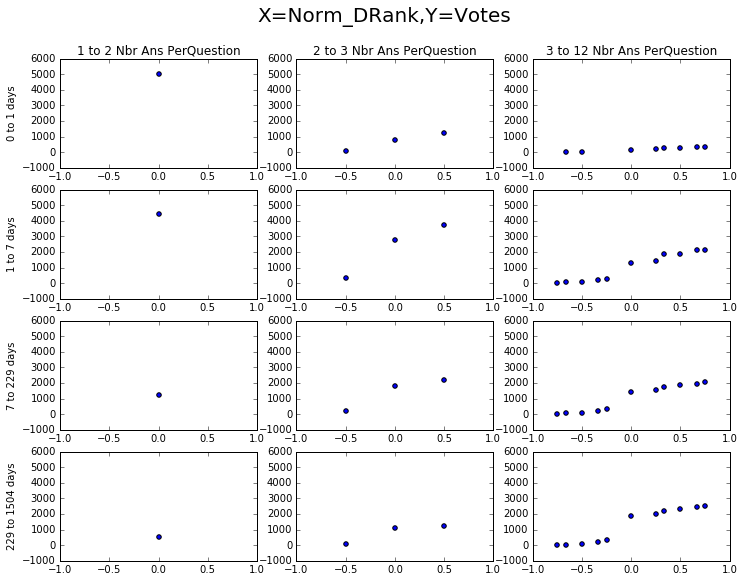

In [512]:
nb_ans = 4
nb_age_groups = 4
data = votes[(votes['Ans_count']<=nb_ans)&(votes['Age_vot_group']<=nb_age_groups-1)]
plot_by(data,'Age_vot','Ans_count','Norm_DRank','Votes',12,9)

[]


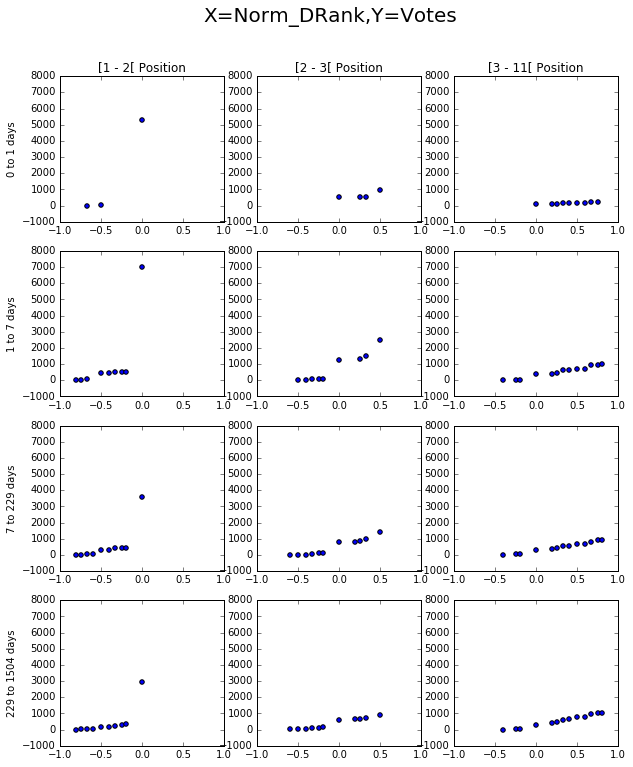

In [513]:
nb_ans = 5
nb_age_groups = 4
data = votes[(votes['Ans_count']<=nb_ans)&(votes['Age_vot_group']<=nb_age_groups-1)]
plot_by(data,'Age_vot','AnsRank','Norm_DRank','Votes',10,12)

[(0, 1), (0, 3), (0, 4), (0, 5)]


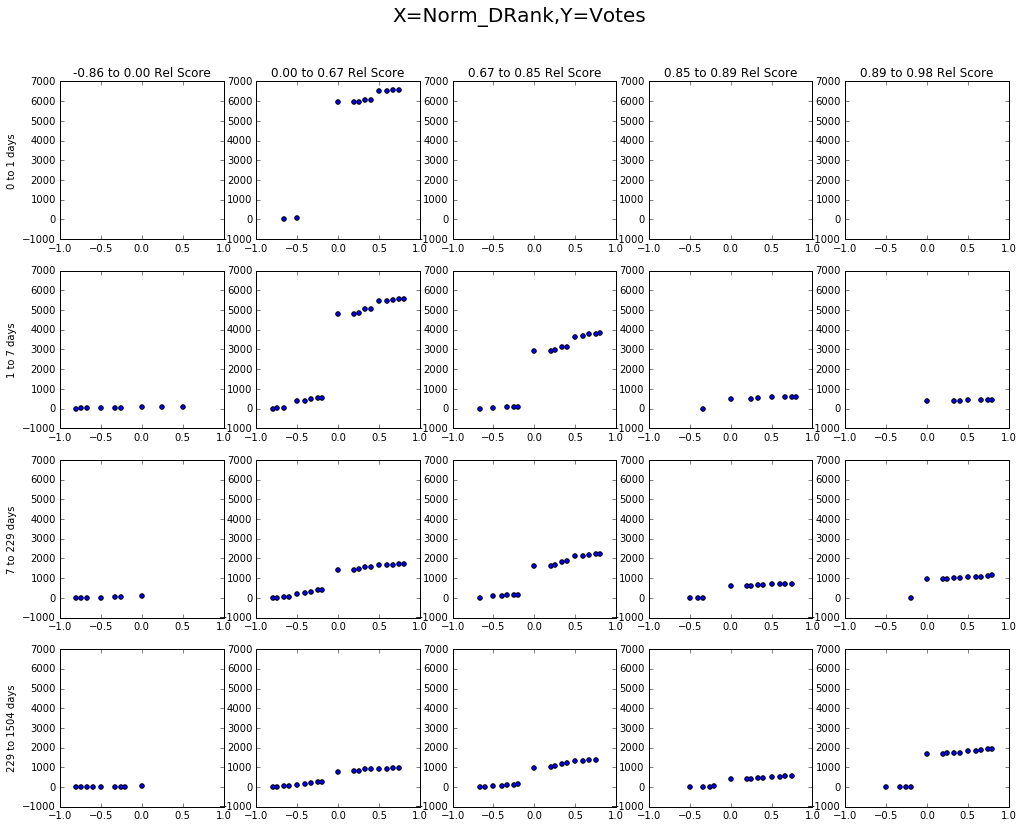

In [514]:
nb_ans = 5
nb_age_groups = 4
data = votes[(votes['Ans_count']<=nb_ans)&(votes['Age_vot_group']<=nb_age_groups-1)]
plot_by(data,'Age_vot','ReScore','Norm_DRank','Votes',17,13)

[]


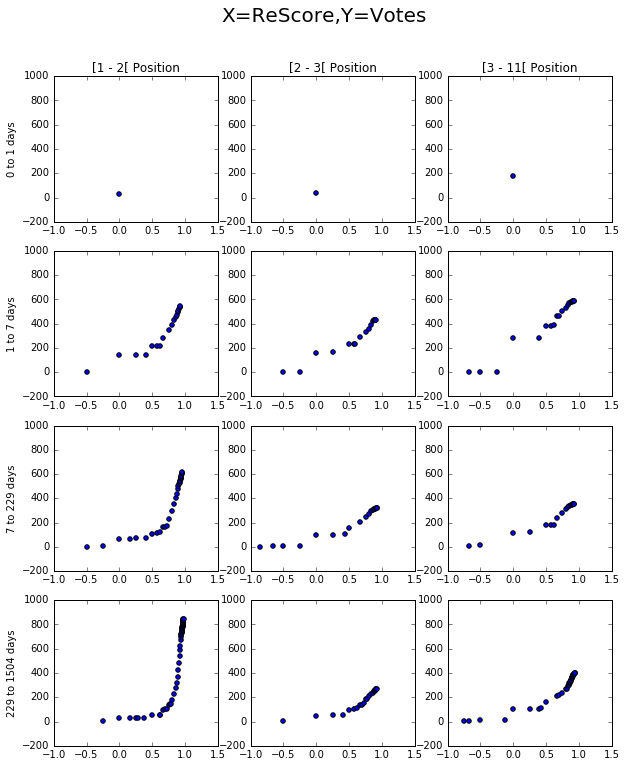

In [516]:
nb_ans = 3
nb_age_groups = 4
data = votes[(votes['Ans_count']==nb_ans)&(votes['Age_vot_group']<=nb_age_groups-1)]
plot_by(data,'Age_vot','AnsRank','ReScore','Votes',10,12)